In [ ]:
!pip install wget --quiet
!pip install simple-lama-inpainting

In [ ]:
import requests
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import base64, os

from google.colab.output import eval_js
from base64 import b64decode
from IPython.display import HTML
import wget
from shutil import copyfile
import shutil
from google.colab import files
from io import BytesIO

In [ ]:
# Provide options for the user to choose either upload or URL
user_choice = input("Enter 'upload' to upload an image, or 'url' to provide an image URL: ").lower()

if user_choice == 'upload':
    fname = None
else:
    fname = input("Enter the image URL: ")

if fname is None:
  files = files.upload()
  fname = list(files.keys())[0]
else:
  fname = wget.download(fname)

Enter 'upload' to upload an image, or 'url' to provide an image URL: upload


Saving test1.jpg to test1.jpg


In [ ]:
# # fname = None
# fname = 'https://ic.pics.livejournal.com/mostovoy/28566193/1224276/1224276_original.jpg' # <-in the example
# # fname = 'https://raw.githubusercontent.com/senya-ashukha/senya-ashukha.github.io/master/images/1010286.jpeg'
# # fname = 'https://raw.githubusercontent.com/senya-ashukha/senya-ashukha.github.io/master/images/1010287.jpeg'
# # fname = "https://raw.githubusercontent.com/senya-ashukha/senya-ashukha.github.io/master/images/alex.jpg"

In [ ]:
canvas_html = """
<style>
.button {
  background-color: #4CAF50;
  border: none;
  color: white;
  padding: 15px 32px;
  text-align: center;
  text-decoration: none;
  display: inline-block;
  font-size: 16px;
  margin: 4px 2px;
  cursor: pointer;
}
</style>
<canvas1 width=%d height=%d>
</canvas1>
<canvas width=%d height=%d>
</canvas>

<button class="button">Finish</button>
<script>
var canvas = document.querySelector('canvas')
var ctx = canvas.getContext('2d')

var canvas1 = document.querySelector('canvas1')
var ctx1 = canvas.getContext('2d')


ctx.strokeStyle = 'red';

var img = new Image();
img.src = "data:image/%s;charset=utf-8;base64,%s";
console.log(img)
img.onload = function() {
  ctx1.drawImage(img, 0, 0);
};
img.crossOrigin = 'Anonymous';

ctx.clearRect(0, 0, canvas.width, canvas.height);

ctx.lineWidth = %d
var button = document.querySelector('button')
var mouse = {x: 0, y: 0}

canvas.addEventListener('mousemove', function(e) {
  mouse.x = e.pageX - this.offsetLeft
  mouse.y = e.pageY - this.offsetTop
})
canvas.onmousedown = ()=>{
  ctx.beginPath()
  ctx.moveTo(mouse.x, mouse.y)
  canvas.addEventListener('mousemove', onPaint)
}
canvas.onmouseup = ()=>{
  canvas.removeEventListener('mousemove', onPaint)
}
var onPaint = ()=>{
  ctx.lineTo(mouse.x, mouse.y)
  ctx.stroke()
}

var data = new Promise(resolve=>{
  button.onclick = ()=>{
    resolve(canvas.toDataURL('image/png'))
  }
})
</script>
"""

def draw(imgm, filename='drawing.png', w=400, h=200, line_width=1):
  display(HTML(canvas_html % (w, h, w,h, filename.split('.')[-1], imgm, line_width)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)

Will use ./data_for_prediction/test1.jpg for inpainting


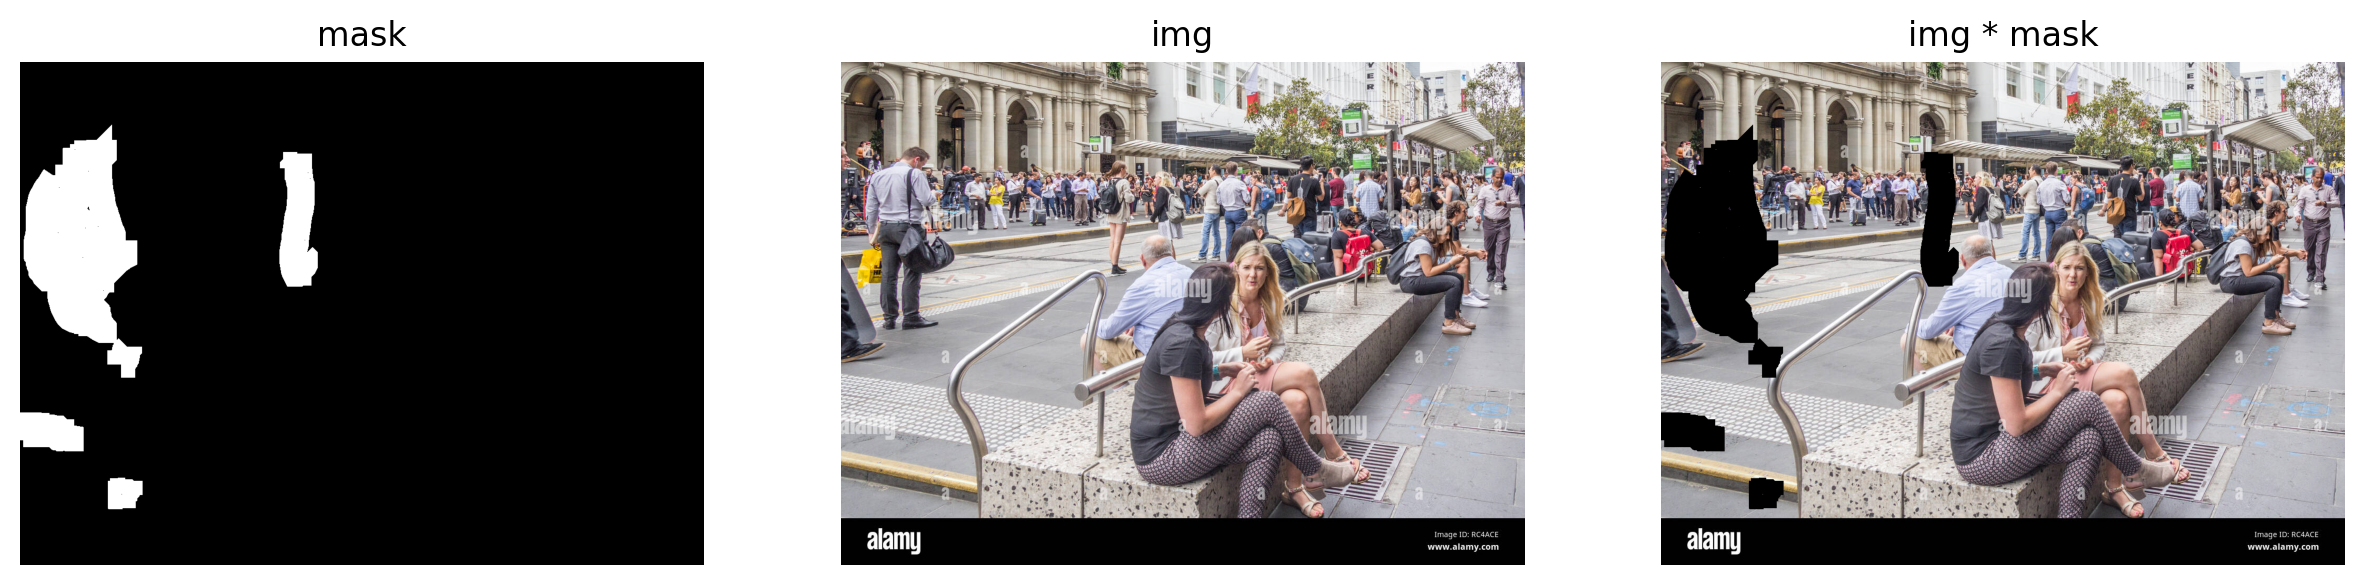

Run inpainting


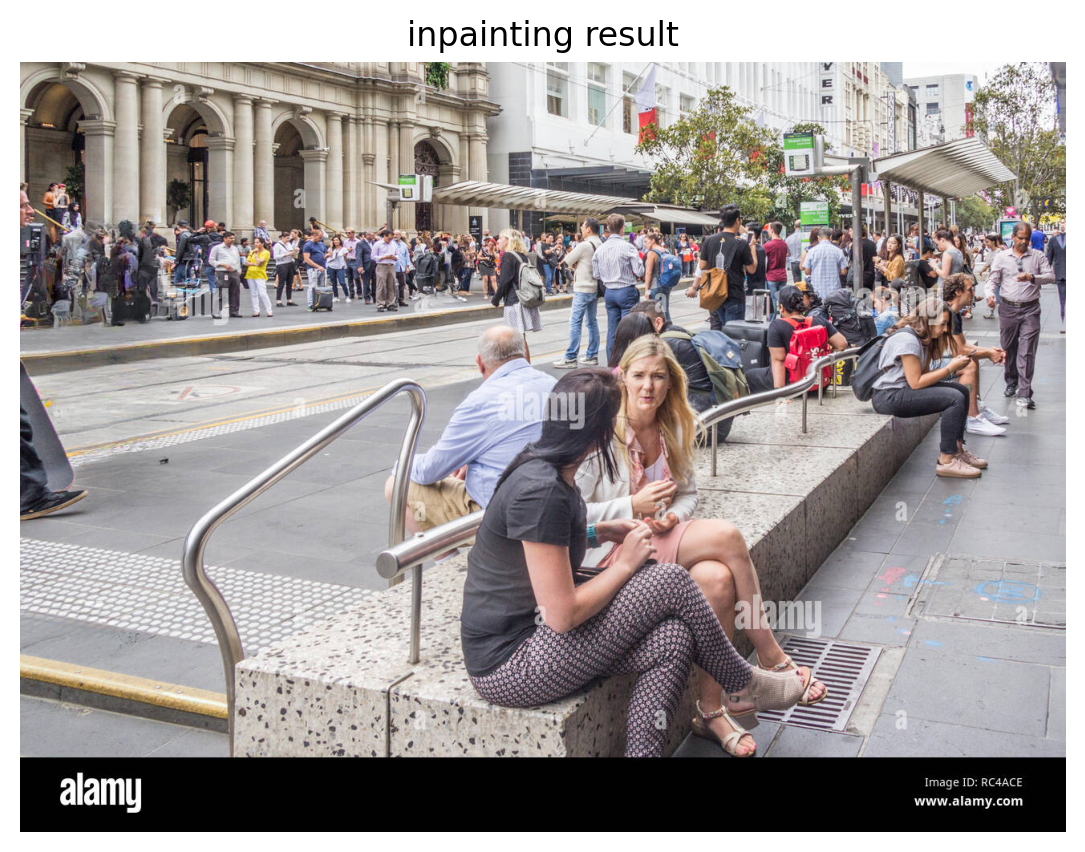

In [ ]:
shutil.rmtree('./data_for_prediction', ignore_errors=True)
!mkdir data_for_prediction

copyfile(fname, f'./data_for_prediction/{fname}')
os.remove(fname)
fname = f'./data_for_prediction/{fname}'

image64 = base64.b64encode(open(fname, 'rb').read())
image64 = image64.decode('utf-8')

print(f'Will use {fname} for inpainting')
img = np.array(plt.imread(f'{fname}')[:,:,:3])

draw(image64, filename=f"./{fname.split('.')[1]}_mask.png", w=img.shape[1], h=img.shape[0], line_width=0.04*img.shape[1])

plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams['figure.dpi'] = 200
plt.subplot(131)
with_mask = np.array(plt.imread(f"./{fname.split('.')[1]}_mask.png")[:,:,:3])
mask = (with_mask[:,:,0]==1)*(with_mask[:,:,1]==0)*(with_mask[:,:,2]==0)
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.title('mask')
plt.imsave(f"./{fname.split('.')[1]}_mask.png",mask, cmap='gray')

plt.subplot(132)
img = np.array(plt.imread(f'{fname}')[:,:,:3])
plt.imshow(img)
plt.axis('off')
plt.title('img')

plt.subplot(133)
img = np.array((1-mask.reshape(mask.shape[0], mask.shape[1], -1))*plt.imread(fname)[:,:,:3])
_=plt.imshow(img)
_=plt.axis('off')
_=plt.title('img * mask')
plt.show()

# Set the path to the original image
org_image_path = './data_for_prediction/' + fname.split('/')[-1]

# Set the path to the mask
mask_path = f"./{fname.split('.')[1]}_mask.png"


print('Run inpainting')

from simple_lama_inpainting import SimpleLama
from PIL import Image

simple_lama = SimpleLama()

image = Image.open(org_image_path)
mask = Image.open(mask_path).convert('L')

result = simple_lama(image, mask)
result.save("inpainted.png")

plt.rcParams['figure.dpi'] = 200
plt.imshow(plt.imread(f"/content/inpainted.png"))
_=plt.axis('off')
_=plt.title('inpainting result')
plt.show()
fname = None